## Assignment 2 - _Foundations of Information Retrieval 2023_

The second assignment is divided in two parts and it is due on October 29th at 23:59, via Canvas (no deadline extentions).
The first part is about _learning-to-rank_ exercises and the use of a regression and SVM for ranking. You will work on a data set of document, for which two features are extracted. The second part contains small practical image retrieval exercises using the Bag-of-Words framework, using images of the city of London.

### Background information
Please study the materials provided with Lecture 4 (for Part 01) and Lecture 6 (for Part 02) to have a solid theoretical base to solve the following exercises. 

To simplify many operations, you can use Python libraries for Machine Learning (for Part 01 and Part 02) and Image Processing (only for Part 02). We advise you to familiarize with:
* [scikit-learn](): library for Machine Learning
* [scikit-image](): library of functions for image processing 
* [matplotlib](): for visualizations and plots

### Install needed libraries and tools
The required libraries are already installed in the virtual machine system.
If you run the notebook on your machine, you can install the libraries by running the cell below.

In [ ]:
import scipy.stats
# Scikit-image library for image processing tools in python
!pip3 install scikit-image
# Scikit-learn library for ML in python
!pip3 install scikit-learn
# install the library h5py (needed to load and read the ground truth relevance file of assignment 02)
!pip3 install h5py
# install the library tqdm (for progress visualization)
!pip3 install tqdm
# Matplotlib/Pylab for plots and visualization in python
!pip3 install matplotlib

# Part 01: _Learning-to-rank_

Ranking problems are formulated for data sets that consist of lists of items with some ordering specifications. The order specifications are usually defined by giving a numerical score or a binary judgement (relevant/non-relevant) for each item so that for any two samples `x` and `y`, either `x < y`, `x > y` or `b` and `a` are not comparable. See the lecture material for more details.

### Data set and preparation
You will work with a synthetic data set (with no specific domain) and focus on the methodological aspects of learning-to-rank methods.

The data set contains $300$ documents (for which, 2-element feature vectors are computed, i.e. each document is represented by two features), divided into 210 training and 90 test samples. An ordering rule, defined by given coefficients, is applied to generate the samples in a ranked way and simulate the characteristics of a ranking problem. For each sample in the data set, a target value is specified as a label from the set Y = {0, 1, 2}. 

The training set is built in such a way that there are two blocks of data, which represent two sets of documents that compose our collection.

In the following we provide the code to load and visualize the data (and the train/test split). The two groups of training data are marked by flags in the variable `distID_train`, which contains a 0 if the corresponding document is in the first set, and a 1 otherwise. Eventually explore more deeply the data structures and their content.

In [ ]:
import itertools
import numpy as np
from scipy import stats
import pylab as pl
from sklearn import svm, linear_model, model_selection
import pickle


# load pre-computed descriptors
f = open('data02/data-ltr.bin', 'rb')
dataset = pickle.load(f)
distID_train = dataset['distID_train'] 
X_train = dataset['X_train']
y_train = dataset['y_train']
X_test = dataset['X_test']
y_test = dataset['y_test']
w = dataset['w']
f.close()

### Visualize the training data points
To have a better idea of the data set, we can plot them. 

For visualization purposes, we use different colors to mark the target class, and different marker shapes to indicate the block to which the samples belong, i.e. a triangle for block 1 and a circle to for block 2. The blocks refer to the documents associated to query 1 and query 2, respectively.

The horizontal gray line is the ground truth _ranking vector (direction)_. See slides of the lecture ('Ordinal regression').


In [ ]:
import matplotlib.patches as mpatches

# Plot the training samples
idx = (distID_train == 0)  # select the samples from the first distribution centered in (0,0)
pl.scatter(X_train[idx, 0], X_train[idx, 1], 
           c=y_train[idx], marker='^', 
           cmap=pl.cm.Paired, s=100, edgecolors='k')

# ~idx contains the indices of the samples from distribution 2
pl.scatter(X_train[~idx, 0], X_train[~idx, 1], 
           c=y_train[~idx], marker='o', 
           cmap=pl.cm.Paired, s=100, edgecolors='k')

# Plot the ground truth ranking line
x_space = np.linspace(X_train[:,0].min(), X_train[:,0].max())
pl.plot(x_space * w[0], x_space * w[1] + X_train[:,1].mean(), color='gray')

cm = pl.cm.get_cmap('Paired')
pl.legend(loc='lower right',
          handles=[mpatches.Patch(facecolor=cm(0.), edgecolor='k', label='Rank 0'),
                  mpatches.Patch(facecolor=cm(0.5), edgecolor='k', label='Rank 1'),
                  mpatches.Patch(facecolor=cm(1.), edgecolor='k', label='Rank 2'),])

#pl.axis('equal')
pl.title('Training data')
pl.show()




It is interesting to notice how for both blocks of data, there is a ranking vector. This means that, if we project the samples onto this vector, we have an ordered list of the documents (note that the vector is direction onto which we can project the document samples and achieve a ranking) - see the lecture slides for details about ordinal regression.

Thus, using ML techniques to estimate the coefficients of this vector from the training data qualifies as a `learning-to-rank` approach.

> _note:_ we could plot the vector bacause we know the ground truth coefficients $w$, as we used them to generate the data. In a real-world case, you do not know these coefficients and need to estimate them from scratch.

### Visualization of the test data points
Plot of the test data points. Note that they are drawn from a distribution of the same shape of the two parts of the training data, but centered in a different region of the feature space.

In [ ]:
# Plot of test data
pl.scatter(X_test[:, 0], X_test[:, 1], 
           c=y_test, marker='^', 
           cmap=pl.cm.Paired, s=100, edgecolors='k')

#pl.axis('equal')
pl.title('Test data')
pl.show()

print(X_train.shape)
print(X_test.shape)

### Training data and test data
For visualization purpose, below the training data points (circles and triangles of light blue, light orange and brown color) and test data (squares of light green, blue and dark grey color) are show.

In [ ]:
# Plot of training data
idx = (distID_train == 0)  # select the samples from the first distribution centered in (0,0)
pl.scatter(X_train[idx, 0], X_train[idx, 1], 
           c=y_train[idx], marker='^', 
           cmap=pl.cm.Paired, s=100)

# ~idx contains the indices of the samples from distribution 2
pl.scatter(X_train[~idx, 0], X_train[~idx, 1], 
           c=y_train[~idx], marker='o', 
           cmap=pl.cm.Paired, s=100)

# Plot of test data
pl.scatter(X_test[:, 0], X_test[:, 1], 
           c=y_test, marker='s', 
           cmap=pl.cm.Accent, s=100, edgecolors='k')

#pl.axis('equal')
pl.title('Training and test data')
pl.show()

## Exercise 01.A: _(Pointwise) Regression-based ranking_

We can implement a regression-based approach to estimate the coefficients of a ranking model (the vector w) and use these coefficients to rank the documents in the test set. We want to learn the parameters of a model using an optimization method, so that we can use it to rank test documents given their feature-vector representation.

__1(a). Use the fecture vectors in the training set `X_train` and the corresponding labels `y_train` to learn a regression model. Save the estimated coefficients in the variable `coef` (a vector of 2 elements, because we have 2 features), which is used by the visualization code in the following notebook cell.__


> _Hint:_ look into the [Linear Models](https://scikit-learn.org/stable/modules/linear_model.html) class of methods in scikit-learn.
>

__1(b).Use different regression models and compare the data points and resulting ranking vector.__ 
We provide you with the code for plotting the results. Feel free to modify it (f.i. if you want to plot the ranking vector computed with more than one model).

In [ ]:
from sklearn.svm import SVR

# your code here
## BEGIN ANSWER
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

ridge = linear_model.Ridge(alpha=.5)
ridge.fit(X_train, y_train)

lasso = linear_model.Lasso(alpha=1)
lasso.fit(X_train, y_train)

coef = lasso.coef_


## END ANSWER

# Remember to fill in the variable `coef` with the 2 estimated coefficients of the vector. 
# We use the `coef` variable for plotting purposes in the following cell
print(coef)

The following cells plots the training data points and the ranking vectors.

The red vector indicates the ground truth direction that we should aim at estimate (which in our case provides the optimal ranking according to the relevance judgements). The grey vector is the result of the estimation using a regression-based approach.

In [ ]:
# Plot the training samples and the estimated ranking model (vector w)
# NOTE: we use the block indices (idx and ~idx) computed before only for a visualization purpose
pl.scatter(X_train[idx, 0], X_train[idx, 1], 
           c=y_train[idx], marker='^', 
           cmap=pl.cm.Paired, s=100, edgecolors='k')

# ~idx contains the indices of the samples from distribution 2
pl.scatter(X_train[~idx, 0], X_train[~idx, 1], 
           c=y_train[~idx], marker='o', 
           cmap=pl.cm.Paired, s=100, edgecolors='k')

# plot the estimated ranking vector (line)
x_space = np.linspace(X_train[:,0].min(), X_train[:,0].max())
pl.plot(x_space * coef[0], x_space * coef[1] + X_train[:,1].mean(), color='gray')

# plot ground truth coefficients (those used for data generation)
x_space = np.linspace(X_train[:,0].min(), X_train[:,0].max())
pl.plot(x_space * w[0], x_space * w[1] + X_train[:,1].mean(), color='red')



#pl.axis('equal')
pl.title('Estimation by linear regression')

cm = pl.cm.get_cmap('Paired')
pl.legend(loc='lower right',
          handles=[mpatches.Patch(facecolor=cm(0.), edgecolor='k', label='Rank 0'),
                  mpatches.Patch(facecolor=cm(0.5), edgecolor='k', label='Rank 1'),
                  mpatches.Patch(facecolor=cm(1.), edgecolor='k', label='Rank 2'),])

pl.show()

__2. Make your own observations on the visual results that you got above, including the cases when you used different regression models. Answer as a comment in the cell below.__

In [ ]:
# your answer below
## BEGIN ANSWER
# We tried two different methods to find the coefficients of the ranking vector.
# First, we used both queries to determine the coefficients, but this lead to a diagonal line with linear regression
# and ridge regression. However, when using lasso and setting alpha to 1, it resulted in a horizontal line.
# We are not sure why Lasso results in a horizontal line while linear and ridge regression do not.
# Next, we used only one query to determine the coefficients. This lead to horizontal lines for all models.
## END ANSWER

## Exercise 01.B: _performance of regression-based ranking (Kendall's Tau)_

Evaluate the performance of the learned model by using it to rank the test set and comparing it to the target labels.
As the problem you are working with is a ranking problem, you need to use a measure of performance that is based on a ranking score, that is you need to compare the _order_ of the retrieved documents by your model with the _order_ of the ground truth data.

In the lecture, we have seen that the [Kendall's tau correlation coefficient](http://en.wikipedia.org/wiki/Kendall_tau_rank_correlation_coefficient) is a measure of the quality of data ordering with respect to a given ground truth ordering. It is defined as (P - Q)/(P + Q), where P is the number of concordant pairs and Q is the number of discordant pairs.

__1. Compute the Kendall's Tau on the ranking order that you obtain by applying your regression model to the documents in the test set `X_test` with labels `y_test`.__

> Look into [Scipy's Stats library](https://docs.scipy.org/doc/scipy/reference/stats.html) for hints on how to compute the [Kendall's tau](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html#scipy.stats.kendalltau). 

In [ ]:
## BEGIN ANSWER
X_rank = np.zeros((X_test.shape[0], 2))

coef = reg.coef_
for i in range(X_test.shape[0]):
    X_rank[i, :] = np.dot(X_test[i, :], coef) / np.linalg.norm(coef) * coef / np.linalg.norm(coef)

pl.scatter(X_rank[:, 0], X_rank[:, 1], c=y_test)

tao_1 = stats.kendalltau(X_rank[:, 0], y_test)

print(tao_1.statistic)


## END ANSWER

__2. Compute the Kendal's Tau of the ranking order that you obtain by applying your regression model and that you can obtain by applying the ground truth ranking vector $w$. Make your observations below.__

In [ ]:
## BEGIN ANSWER
tao_2 = stats.kendalltau(X_test[:, 0], y_test)
print(tao_2)
## END ANSWER

In [ ]:
# your observations below
## BEGIN ANSWER
# We can see that the Kendel's Tau values are exactly the same. This is because our ranking vector is almost equal to the ground truth vector and therefore they have the same amount of concordant and discordant pairs. If we compute the Kendel's Tau value on the ranking vector computed with regular linear regression, which resulted in a more diagonal vector, the value became much lower (0.5516379557934487).

## END ANSWER

## Classifiers for ranking problems 

A ranking problem can be transformed into a classification problem by manipulating the training data (feature vectors and ordinal labels). One can transform the training data by computing all the pairwise differences of the feature vectors $x_i$ and corresponding labels $y_i$ as:

$(\mathbf{x'_k}, y'_k) = \left(\mathbf{x_i} - \mathbf{x_j}, sign(y_i - y_j)\right)$

In the case we have $N$ documents (represented by $N$ feature vectors), the pairwise transformed data will be composed by $N(N-1)/2$ feature vectors (and corresponding labels). In this way, the input training data with multiple ordinal targets are transformed into a two-class data set, suitable for linear classification algorithms.

## _Pairwise transform_
As seen in the lecture, the pairwise transform translates your dataset of single documents (with labels) into a dataset of pairs of documents (with labels related to the pairs - see Lecture 05 slides). You will use (in later parts of the assignment) the dataset that results from the pairwise transformation to train a ranking model (using an SVM classifier).

Here, we provide the code to perform the pairwise transform of the training data. Read and understand it, before using it.

In [ ]:
# form all pairwise combinations
comb = itertools.combinations(range(X_train.shape[0]), 2)
k = 0
X_pw, y_pw, diff = [], [], []
for (i, j) in comb:
    #print(i, j, y_train[i], y_train[j])
    if y_train[i] == y_train[j] \
        or distID_train[i] != distID_train[j]:
        # skip if same target or different group
        continue
    X_pw.append(X_train[i] - X_train[j])
    diff.append(y_train[i] - y_train[j])
    y_pw.append(np.sign(diff[-1]))
    # output balanced classes
    if y_pw[-1] != (-1) ** k:
        y_pw[-1] *= -1
        X_pw[-1] *= -1
        diff[-1] *= -1
    k += 1
    
X_pw, y_pw, diff = map(np.asanyarray, (X_pw, y_pw, diff))
# Plot the transformed data set 
# (note that the number of points -- documents -- increases 
# due to the all the pairwise combination of documents)    

# We use X_pw and y_pw to indicate the transformed data points and the corresponding labels, respectively
pl.scatter(X_pw[:, 0], X_pw[:, 1], c=diff, s=60, 
           marker='o', edgecolors='k', cmap=pl.cm.Paired)

x_space = np.linspace(-10, 10)
pl.plot(x_space * w[1], 3* x_space * w[0], color='gray')  # this is the expected separation plane (from the ground truth coefficients)
pl.title('Pairwise transformed training data')
pl.show()


## Exercise 01.C: _ranking SVM_

After pairwise transformaion, the classification problem looks (almost) linearly separable, i.e. a line can be drawn that separates the two sets of document pair points. This is not always the case - however, you can still use an SVM then, allowing for errors).


### SVM implementation
__1. Write the code to train a ranking SVM model on the pairwise transformed data. The model will estimate the coefficients of the ranking vector (we call if `coef` in the code below), which you can use to rank the test documents as explained above.__

Study the SVM from the lecture materials and from [online resources](https://en.wikipedia.org/wiki/Support_vector_machine).
Read the documentation of the [Scikit-learn SVM package](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (the attribute `coef_` will turn to be useful).

> _Hint:_ explore the impact of parameter C of the SVM on the classification results. Look into the generalization capabilities of the model.
>
> We provide the code for generation of the plot. If you need, you can modify it.

In [ ]:
# your code here
## BEGIN ANSWER
from sklearn.svm import SVC

svc = SVC(kernel='linear', C=.2)
svc.fit(X_pw, y_pw)

coef = svc.coef_[0]
## END ANSWER

# value of the estimated coefficients
print('Estimated coefficients: ', coef)
print('Ground truth coefficients: ', w)

# plot the training data and the coefficient vector 
pl.scatter(X_train[idx, 0], X_train[idx, 1], 
           c=y_train[idx], marker='^', 
           cmap=pl.cm.Paired, s=100, edgecolors='k')

# ~idx contains the indices of the samples from distribution 2
pl.scatter(X_train[~idx, 0], X_train[~idx, 1], 
           c=y_train[~idx], marker='o', 
           cmap=pl.cm.Paired, s=100, edgecolors='k')


# plot ground truth coefficients (those used for data generation)
x_space = np.linspace(X_train[:,0].min(), X_train[:,0].max())
pl.plot(x_space * w[0], x_space * w[1] + X_train[:,1].mean(), color='red')

# plot the estimated ranking vector (line)
x_space = np.linspace(X_train[:,0].min(), X_train[:,0].max())
pl.plot(x_space * coef[0], x_space * coef[1] + X_train[:,1].mean(), color='gray')

pl.title('Estimation by ranking SVM')
cm = pl.cm.get_cmap('Paired')
pl.legend(loc='lower right',
          handles=[mpatches.Patch(facecolor=cm(0.), edgecolor='k', label='Target 0'),
                  mpatches.Patch(facecolor=cm(0.5), edgecolor='k', label='Target 1'),
                  mpatches.Patch(facecolor=cm(1.), edgecolor='k', label='Target 2'),])

pl.show()


__2. Make your own observations on the visual results that you got above, eventually including the cases when you used SVMs trained with different C values. Answer as a comment in the cell below.__

In [ ]:
# write your observations below, as a comment
## BEGIN ANSWER
# The C value of the SVM does not seem to have much influence on the resulting projection vector. We think this is because the data is balanced, meaning that when we are allowing for misclassifications, roughly an equal amount will occur on each side of the line keeping it in the same direction. It is also again close to the ground truth.
## END ANSWER

## Exercise 01.E: _performance of ranking SVM_

__1. Evaluate the Kendall's Tau score of the ranking SVM Model applied to the test documents. Compare the results with the regression models and make your own observations (you can write them as comments in the cell below, or you can create a new cell).__

> Note that the SVM predicts a binary class, which will contrast with the ordinal prediction required to compute the Kendall's tau. You should thus use the vector of coefficients learned by the ranking SVM to perform the projections of the test samples and obtain an ordinal categorization. To perform the projection operation you may want to use the [NumPy dot product function](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.dot.html).

In [ ]:
# your code here
## BEGIN ANSWER
X_rank = np.zeros((X_test.shape[0], 2))

coef = svc.coef_[0]
for i in range(X_test.shape[0]):
    X_rank[i, :] = np.dot(X_test[i, :], coef) / np.linalg.norm(coef) * coef / np.linalg.norm(coef)

pl.scatter(X_rank[:, 0], X_rank[:, 1], c=y_test)

tao_1 = stats.kendalltau(X_rank[:, 0], y_test)

print(tao_1.statistic)
## END ANSWER

__2. Compute the Kendal's Tau of the ranking order obtained by applying your SVM model when compared to that you obtain by applying the ground truth ranking vector $w$. Make your observations below.__

In [ ]:
## BEGIN ANSWER
tao_2 = stats.kendalltau(X_test[:, 0], y_test)
print(tao_2.statistic)
## END ANSWER

In [ ]:
# write your observations below
## BEGIN ANSWER
# We have the same observation as before. Because our projection vector is very close to the ground truth, we have the same amount of concordant and discordant pairs, resulting in an equal Kendal's Tau.
## END ANSWER

# Part 02: Image Retrieval

_You are suggested to work on this part after Lecture 06 (Multimedia Information Retrieval - Image Retrieval)_

In the second part of the assignment, you will work on a simple image retrieval problem, and implement parts of the Bag Of Words retrieval approach. You will work with images from the Mapillary Street-Level Sequences  (MSLS) data set. For an autonomous car, for instance, it is important to retrieve from a map or reference set of images the most similar images to what is being recording with a camera, in order to recognize a previously visited place.

You are asked to retrieve, from a collection of city images (we work with images from London), the most similar images to given queries. For this, we provide you a dataset, composed of:

* _database/_ folder: contains XXX images used as map (document collection)
* _query/_ folder: contains XXX images used as queries
* _database/database_lite.json_: list of images included in the map (the order is important because it correspond to the orded in the similarity matrix - see below)
* _query/query_lite.json_: list of images used for query (the order is important because it correspond to the orded in the similarity matrix - see below)
* _london_lite_gt.h5_: matrix of image similarity, containts all the information about relevant/non-relevant images 

__Relevance judgements (in the form of a matrix, the structure of which is explained below)__
For each query image, we provide a specification of which map images are relevant (1 in the london_lite_gt.h5 file) and which are not (0 in the london_lite_gt.h5). The content of the '.h5' file is a matrix, with rows corresponding to query images and columns corresponding to the map images. The matrix has thus has $N=500$ rows (where $N$ is the number of query images in the folder `query/images/`) and $M=1000$ columns (where $M$ is the number of query images in the folder `database/images/`). 

The $i$-th row of the matrix thus contains the relevance judgement for the $i$-th query image with respect to the map images. For instance, row 5 of the matrix is a vector of 1000 elements (one for each image in the map), in which each element is 1 if the corresponding map image is relevant for the query image 5, or $0$ in case it is not relevant.

Please note that in Python the index of a vector (or matrix) starts from 0 (instead of 1). This means that the first element of a vector has index $0$, and that, for example, the element with index $25$ corresponds to the 26-th element of the vector. 
Thus, as an example, the cell $(10, 25)$ contains the relevance of the 26-th map image for the $11$-th query image (i.e. is the 26-th image in the map relevan (1) or not (0) for the query image number 11?).
 

In the following, we provide you the code for loading the data set and to visualize the images.


> Note: for this assignment we use the '\_lite' version of the map and query set, which include a reduced number of images. This is to simplify the computations required to work on this assignment. For the final project, you can work using the full-sized sets of images from London. This will require longer computations, but you can obtain more reliable results.

## Load the query and map images
In the following we load the list of images in the map set (collection) and in the query set.
For each image, we have information also about the absolute coordinates of the camera that took the picture in the city of London. _Do not consider these coordinates for the exercises. We use them only to show the trajectory followed by the camera taking the pictures (see below)._ 

In [1]:
import json
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tqdm

# map
with open("data02/database/database_lite.json","r") as f:
    m_idx = json.load(f)
    m_imgs = np.array(m_idx["im_paths"])
    m_loc=np.array(m_idx["loc"])

# query
with open("data02/query/query_lite.json","r") as f:
    q_idx=json.load(f)
    q_imgs=np.array(q_idx["im_paths"])
    q_loc=np.array(q_idx["loc"])


### Visualization of image locations
The pictures in the map (collection) and query sets have been recorded in different parts of the city of London. The map images are indicated by the blue trajectory (run the code below), while the query images are indicated by the orange trajectory segments.

You can notice how the blue and orange trajectories overlap partially. In that overlapping area, the query images will have some relevant images among the map images. Conversely, in the areas there there is no overlap (and the points are not even close), the map images will be non-relevant for the query images. 
Please read more details in the next sections, where the ground truth relevance judgements are provided and explained.

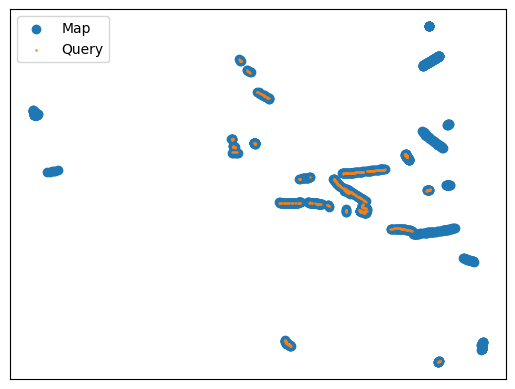

In [2]:
plt.scatter(m_loc[:,0],m_loc[:,1], label="Map")
plt.scatter(q_loc[:,0],q_loc[:,1], label="Query", s=0.5)
#plt.axis("equal")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

## Load the similarity matrix (relevance judgements)

The london_lite_gt.h5 file contains two sets of relevance  judgements, specified by the keys `sim` and `fov`.
`sim` specifies it in the form 0/1 (non-relevant/relevant).
`fov` (that stands for field of view) specifies it as a degree of similarity, a value defined in the interval $[0, 1]$ that indicates how much the query and map images are similar. We do not use it for this assignment, but you may consider it when working on the final project.


In [3]:
# loading the relevance judgements
with h5py.File("data02/london_lite_gt.h5","r") as f:
    fovs = f["fov"][:]
    sim = f["sim"][:].astype(np.uint8)

We use the matrix with binary relevance judgements `sim` in this assignment. 
To obtain the relevance judgement of the map image 'map_id' for the query 'query_id', you  can use the syntax `sim[query_id, map_id]`. 

In the following we show few examples:

In [4]:
# note that for the 10th map image we have to access column 10-1=9
print('Relevance of the 10th map image for the 5th query image: ', sim[4, 9])
# similarly for the 221th query image we access column 221-1=220
print('Relevance of the 221th map image for the 151th query image: ', sim[150, 220])

Relevance of the 10th map image for the 5th query image:  0
Relevance of the 221th map image for the 151th query image:  1


### Distribution of relevant images per query

The majority of query images have between $0$ and $10$ relevant map images (ground truth positive matches). A few query images have no relevant map images (no positive matches) in the database. A few others have up to $30$ positive database images.

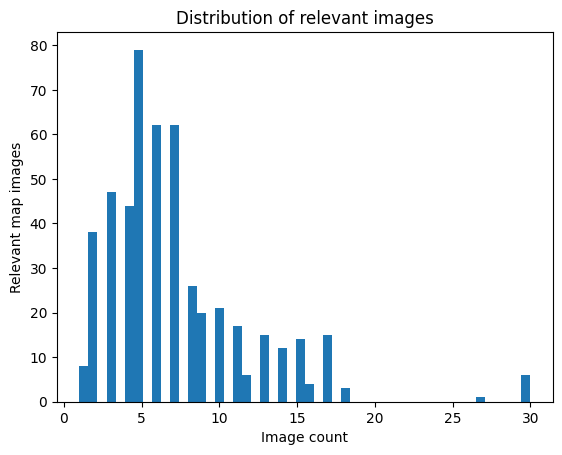

In [5]:
plt.hist(np.sum(sim, axis=1),bins=50)
plt.xlabel('Image count')
plt.ylabel('Relevant map images')
plt.title('Distribution of relevant images')
plt.show()

### Visualization of random images. 
For a given query image, we select one relevant and one non-relevant image from the map.
> By running several time the following cell, you can see how some of the relevant images are very difficult cases. This can give an idea of how complicate is to perform robust image retrieval.
This is also an indication that the retrieval results that you will compute will not be high (do not worry about them, then - focus on the methodology and discussions).

See below:

(-0.5, 340.5, 255.5, -0.5)

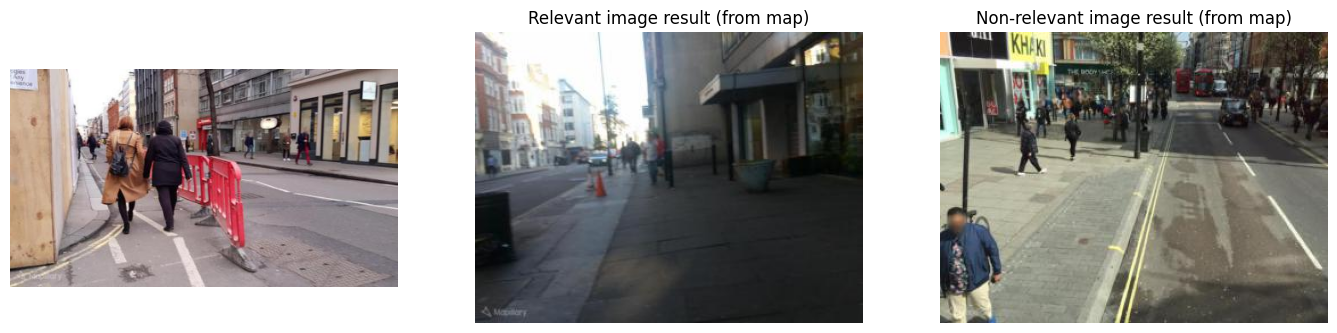

In [6]:
# generate random index for the query image
# You can try with it (but in the case a query image does not have relevant results in the map, the code will give an error)
query_idx = np.random.randint(0, 499) 

# For visualization purposes, we select a query image for which there are relevant and non-relevant results in the collection (map)
# query_idx = 120

# select the relevant and non-relevant map images for the randomly selected query image
rel = np.where(sim[query_idx, :] == 1)
nonrel = np.where(sim[query_idx, :] == 0)


# randomly select a relevant and non-relevant image
rel_idx = rel[0][np.random.randint(0, len(rel[0]) - 1)]
nonrel_idx = nonrel[0][np.random.randint(0, len(nonrel[0]) - 1)]

plt.figure(figsize=(17,10))
plt.subplot(1,3,1)
plt.imshow(plt.imread('data02/' + q_imgs[query_idx]))
plt.axis("off")

plt.subplot(1,3,2)
plt.title('Relevant image result (from map)')
plt.imshow(plt.imread('data02/' + m_imgs[rel_idx]))
plt.axis("off")

plt.subplot(1,3,3)
plt.title('Non-relevant image result (from map)')
plt.imshow(plt.imread('data02/' + m_imgs[nonrel_idx]))
plt.axis("off")



If you want to collect all relevance judgement for the $i$-th query image, you need to access the (i-1)-th row of the matrix `sim`. To visualize the relevance judgment you have to loop over the accesses vector (a row of a matrix is a vector.

In the following an example of how to do that.

In [7]:
# accessing (and printing out) the relevance judgement for the query image number 16

query_id = 15  # 16-1
for idx in range(len(sim[query_id, :])):
    # idx is the index of the vector. It corresponds to the map image index
    # rel contains the relevance (0/1) of the idx-th map image for the considered query image (9th image in our case)
    print("Relevance of the %d-th map image for the 16-th query image: %d" % (idx, sim[query_id, idx]))

Relevance of the 0-th map image for the 16-th query image: 0
Relevance of the 1-th map image for the 16-th query image: 0
Relevance of the 2-th map image for the 16-th query image: 0
Relevance of the 3-th map image for the 16-th query image: 0
Relevance of the 4-th map image for the 16-th query image: 0
Relevance of the 5-th map image for the 16-th query image: 0
Relevance of the 6-th map image for the 16-th query image: 1
Relevance of the 7-th map image for the 16-th query image: 1
Relevance of the 8-th map image for the 16-th query image: 1
Relevance of the 9-th map image for the 16-th query image: 1
Relevance of the 10-th map image for the 16-th query image: 1
Relevance of the 11-th map image for the 16-th query image: 1
Relevance of the 12-th map image for the 16-th query image: 1
Relevance of the 13-th map image for the 16-th query image: 1
Relevance of the 14-th map image for the 16-th query image: 1
Relevance of the 15-th map image for the 16-th query image: 1
Relevance of the 1

# ASSIGNMENT: Bag of Words representation
As seen in the lecture, in order to construct a dictionary of 'visual' terms (words) from a collection of images, one can extract local features from the images (e.g. keypoints) and use a clustering algorithm to automatically find groups (i.e. clusters) of similar local features. The centroid of a cluster is also a feature vector and can be considered as a term to be used for the search and retrieval of similar images.

In this assignment, we use the [$K$-Means clustering algorithm](https://www.youtube.com/watch?v=_aWzGGNrcic) (where $k$ is defined as a parameter by us) to extract the visual dictionary of terms from the images in the map collection (in the cells below you will find more information).

In the following code (please study it), we:
* load the list of images in the map collection
* for each image we extract a maximum of 50 ORB keypoints (local keypoint features). Each keypoint is described by a vector of 256 elements (keypoint descriptor) that describes the local characteristics of the image.
* use the set of keypoint descriptors (50 keypoints * 1000 images = 50000 vectors) as input of the k-Means clustering algorithm
* compute k=32 cluster centroids (which correspond to the 32 terms of our dictionary) - k is a configurable parameter

> __Note:__ Please, find more information about ORB in the [ORB paper](https://ieeexplore.ieee.org/document/6126544) and in the [Scikit Image ORB documentation](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_orb.html).

> __Note 2:__ it may take some time to extract the descriptors from all images. Once extracted you can save them, and reload them when needed. If you change the number of centroids k, then you need to recompute the cluster centers.

In [8]:
import os
import skimage
from skimage.feature import ORB, SIFT
from skimage.color import rgb2gray

# Initialize the ORB descriptor
descriptor_extractor = ORB(n_keypoints=50)
# Initialize the data structure that will contain all the descriptors
descriptors = None

# Loop over map images
for img_name in m_imgs:
    #img = Image.open(os.path.join('data_image_retrieval/', img_name)).convert()
    #img = np.asarray(img)
    img = plt.imread(os.path.join('data02/', img_name))
    img = rgb2gray(img)

    # Extract ORB descriptors
    descriptor_extractor.detect_and_extract(img)
    # keypoints1 = descriptor_extractor.keypoints  # position of the points (not interesting for us)
    descriptors_img = descriptor_extractor.descriptors  # descriptors (the feature vectors)

    # Accumulate the computed descriptors
    if descriptors is None:
        descriptors = descriptors_img
    else:
        descriptors = np.vstack( (descriptors, descriptors_img))
    #print(descriptors.shape)

# We have extracted 50 descriptors per image, for 1000 images. The ORB descriptors have length 256
print(descriptors.shape)

(50000, 256)


Save or load descriptors (comment/uncomment the code accordingly)

In [ ]:
import pickle
# save descriptors (uncomment if you want to save the computed descriptors)
f = open('data02/ORB-descriptors-map.bin', 'wb')
data = pickle.dump(descriptors, f)
f.close()

# load pre-computed descriptors
f = open('data02/ORB-descriptors-map.bin', 'rb')
descriptors = pickle.load(f)
f.close()


## Clustering
Following the Bag of Words framework (see the slides of the lecture), we can define the basic 'words' that compose the images via a clustering algorithm that takes the descriptors of the map images (training) as input. The basic 'words' form a so called visual vocabulary and are learned by grouping together those descriptor vectors that are most similar, i.e. their distance is lower than that between other descriptors.

We do it by using the $K$-Means algorithm: find [here](https://en.wikipedia.org/wiki/K-means_clustering) some more information about KMeans and [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) the reference documentation of the algorithm in Scikit-learn. Also an explanatory video with examples [here](https://www.youtube.com/watch?v=_aWzGGNrcic).

> Note: running the clustering may take few minutes. Once computed, you can save the centroids and subsequently load tham before use. If you change the value of K, you need to recompute the clusters.


In [10]:
import sklearn
from sklearn.cluster import KMeans

# clustering
K = 32  # number of clusters (equivalent to the number of words) we want to estimate
num_initialization = 5 # Number of time the k-means algorithm will be run with different centroid seeds.

# Run the k-means clustering
kmeans = KMeans(n_clusters=K, random_state=0, n_init=num_initialization, verbose=1)
clusters = kmeans.fit(descriptors)  # we use the descriptors extracted from the map (training) images before
centroids = clusters.cluster_centers_

print("Shape of the centroids matrix: ", centroids.shape)
print("We computed ", centroids.shape[0], "centroids of lengh ", centroids.shape[1], " (the same of the descriptor)")
# Rememeber: the centroids can be considered as the words that compose our documents 
# -> in this case the basic components of the images


Initialization complete
Iteration 0, inertia 4650371.0.
Iteration 1, inertia 2761039.610174399.
Iteration 2, inertia 2735277.3147514486.
Iteration 3, inertia 2726774.064754388.
Iteration 4, inertia 2722466.145945961.
Iteration 5, inertia 2719898.049674611.
Iteration 6, inertia 2718234.002680759.
Iteration 7, inertia 2717016.8958648127.
Iteration 8, inertia 2716060.1046896926.
Iteration 9, inertia 2715301.0757536506.
Iteration 10, inertia 2714699.1985634877.
Iteration 11, inertia 2714212.57088818.
Iteration 12, inertia 2713793.853389733.
Iteration 13, inertia 2713418.910348473.
Iteration 14, inertia 2713081.11959728.
Iteration 15, inertia 2712763.7525207815.
Iteration 16, inertia 2712474.356491872.
Iteration 17, inertia 2712203.4883951456.
Iteration 18, inertia 2711959.251858807.
Iteration 19, inertia 2711724.066077599.
Iteration 20, inertia 2711513.079890992.
Iteration 21, inertia 2711293.509213555.
Iteration 22, inertia 2711063.22232983.
Iteration 23, inertia 2710837.44930539.
Iterati

## Exercise 02.A: _'Bag of words' vector computation_

In order to compute the BoW representation of an image, we have to count the occurrences of the visual 'words', i.e. the local features, that we have learned in our visual vocabulary (using the $K$-Means clustering).

Given an image, we do the following:
   * we extract the local descriptors (we are using ORB descriptors in this assignment) 
   * for each descriptor we find the closest 'word' (i.e. the closes cluster centroid) in the visual vocabulary
   * we sum +1 to the counting of the occurence of the 'word' (in this way we construct the histogram of the occurrence of the visual 'words')
    
An image is thus described with a vector (of $K$ elements) that is an histogram of the occurrence of the words in the learned visual vocabulary (similar to the occurrence of words in a text document).  

In the following, implement the core of the function that computes the BoW vector. The function takes as input the centroids of the learned clusters (i.e. the vocabulary of the visual words) and the set of descriptors extracted from an image. It must return the BoW vector.

In [11]:
from tqdm import tqdm
import os
import skimage
from skimage.feature import ORB
from skimage.color import rgb2gray
descriptor_extractor = ORB(n_keypoints=50)


# compute the bag of word vector for an image
def bag_of_words(centroids, img_descriptors):
    n_centroids = centroids.shape[0]  # number of centroids found with the KMeans clustering
    n_descriptors = img_descriptors.shape[0]  # number of descriptors extracted from the image
    
    # initialization of the bag of words (BoW) vector
    # Note that the BoW vector has length equal to the number of cluster centroids
    # The cluster centroids are indeed our visual words, and the BoW will be the histogram of these words found in the given image
    bow_vector = np.zeros(n_centroids)  
    
    for i in range(n_descriptors):
        ## BEGIN ANSWER
        idx = np.argmin(np.linalg.norm(centroids - img_descriptors[i], axis=1), axis=0)
        bow_vector[idx] += 1
        ## END ANSWER
    return bow_vector


# Test the implementation of the BoW vector computation
img = plt.imread(os.path.join('data02/', q_imgs[0]))
img = rgb2gray(img)

descriptor_extractor.detect_and_extract(img)  
# keypoints1 = descriptor_extractor.keypoints  # position of the points (not interesting for us)
query_img_descriptors = descriptor_extractor.descriptors 

bow = bag_of_words(centroids, query_img_descriptors)
print("Size of the bow vector: ", bow.shape)
print("Bow vector: ", bow)


Size of the bow vector:  (32,)
Bow vector:  [3. 2. 0. 4. 0. 0. 1. 0. 7. 4. 1. 0. 0. 2. 2. 0. 2. 1. 4. 0. 0. 2. 4. 0.
 1. 2. 2. 0. 4. 1. 1. 0.]


### Bag of words representation of the map images 
Given a query image, our aim is to find similar images in our collection (i.e. map) images.
To do that, we have to convert the query image into its Bag of words (BoW) representation and look for similar vectors in the collection (i.e. map) images.

At this stage, since we will do many queries, it is handy to compute the BoW vectors for all images in the collection (i.e. map) and reuse them for multiple queries. (We convert all images in the collection to their BoW representation).

> It is advised to study and understand the code below (it may take some time to run).

In [ ]:
bow_map_images = None
# loop over the images in the map set
for img_name in tqdm(m_imgs):
    # load image
    img = plt.imread(os.path.join('data02/', img_name))
    img = rgb2gray(img)
    
    # extract the keypoints and corresponding descriptors (50 ORB descriptors)
    descriptor_extractor.detect_and_extract(img)
    img_descriptors = descriptor_extractor.descriptors  # descriptors (the feature vectors)
    
    # compute BoW representation of the image (using the basic 'words', i.e. centroids, computed earlier)
    bow = bag_of_words(centroids, img_descriptors)
    # add the computed BoW vector to the set of map representations
    if bow_map_images is None:
        bow_map_images = bow
    else:
        bow_map_images = np.vstack( (bow_map_images, bow))

At this point, the 1000 images in the map have been converted into their BoW representation. The data structure has size $NxK$, where $N=1000$ is the number of map images, while $K=32$ is the number of basic 'words' of the BoW representation.



In [ ]:
print(bow_map_images.shape)

### Z-score normalization
In machine learning and data analysis problems, it is important to [normalize](https://en.wikipedia.org/wiki/Feature_scaling) (scale) the data, in order to avoid that features with larger range dominate the computation of distances (so skewing the computations). Here we use the Z-score normalization, meaning that we subtract the mean and divide by the variance (computed on the map images) of each feature (i.e. for each dimension of the BoW vectors). We use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) library of Scikit.

> __Note__: when computing the query BoW vectors, then, we need to also normalize them (using the mean and variance of the map vectors).

In [ ]:
from sklearn import preprocessing
orig_bow_map_images = bow_map_images

# Compute z-score statistics
scaler = preprocessing.StandardScaler().fit(bow_map_images)
# Normalize the vectors of the map collection (0 mean and 1 std)
bow_map_images = scaler.transform(bow_map_images)


## Exercise 02B: _Retrieve images_
We are ready to retrieve images from the collection (i.e. map) images, given the BoW representation of a query image. In order to do that, compute the Euclidean distance between the BoW vector of the query image and the BoW vector of all the collection images and return those with the smaller distance. 

_Hint:_ after computing the distances between the query image BoW vector and all BoW vectors of the map image, you may want to sort them in ascending order; the Numpy function [argsort](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html) may turn out to be useful.

> For this exercise you are asked to compute the Euclidean distance, but other distance metrics can also be used, e.g. Cosine distance, Minkowski Distance, Manhattan distance, etc. (this is left to you, if you want to explore them as well)

In [ ]:
# receives as input the:
#   - bag of words vectors of the map images
#   - the bag of work vector of the query image
def retrieve_images(map_bow_vectors, query_bow):
    # n_map_bow_vectors = map_bow_vectors.shape[0]
    # bow_distances = np.zeros(n_map_bow_vectors)
    # most_similar = None  # use this to
    
    ## BEGIN ANSWER
    idxs = np.argsort(np.linalg.norm(map_bow_vectors - query_bow, axis=1))
    ## END ANSWER
    
    return idxs



# Retrieve the most similar images to query image 221 (index 221-1=220)
query_idx = 220
img = plt.imread("data02/" + q_imgs[query_idx])
img = rgb2gray(img)
# compute bag of words
descriptor_extractor.detect_and_extract(img)  
query_img_descriptors = descriptor_extractor.descriptors 
bow = bag_of_words(centroids, query_img_descriptors)

# Normalize the query BoW vector using the mean and variance of the map (computed earlier and saved into the scaler object)
bow = scaler.transform(bow.reshape(-1, 1).transpose())
bow = bow.transpose().reshape(-1)

# Retrieve the indices of the top-10 similar images from the map
retrieved_images = retrieve_images(bow_map_images, bow)
print('Indices of similar images retrieved: ', retrieved_images[:10])
# Indices of the relevant map images for the query: we have the relevance judgements (Ground truth)
relevant_images = np.where(sim[query_idx, :] == 1)[0]
print('Indices of relevant images (given in the GT relevance judgements): ', relevant_images)

## Exercise 02.C: _evaluation of performance_
As now you are able to retrieve images from the map that are similar (according to the BoW framework) to query images, you should evaluate the performance.

You can re-use the `precision_at_k()` function that you have developed for Assignment 01 (on text retrieval) and compute the precision@5 and precision@10 for the retrieval results of the previous exercise (`retrieved_images`).

__Note__ performance might be very low. Do not worry about the results, this problem is very difficult and the implemented solution is a very simple one. Pay instead attention to the implementation and try to make insightful observations.

In [ ]:
## BEGIN ANSWER
def precision_at_k(relevant, retrieved, k):
    tp = np.sum(np.in1d(relevant, retrieved[:k]))
    fp = len(relevant) - tp
    return tp / (tp + fp)

prec5 = precision_at_k(relevant_images, retrieved_images, 5)
prec10 = precision_at_k(relevant_images, retrieved_images, 10)
## END ANSWER

print('P@5: ', prec5)
print('P@10: ', prec10)

## Exercise 02.D (Bonus): _overall performance evaluation_
Extend the previous exercise by computing the Mean Average Precision (MAP) for the whole set of 500 query images.

__Note:__ Implementation of this exercise is completely on your own, without a given code structure, but try to reuse as much as possible the code already available (or that you developed in Assignment 01).


In [ ]:
## BEGIN ANSWER
## BEGIN ANSWER
def average_precision(relevant, retrieved):
    # BEGIN ANSWER
    precisions = []
    for k in range(len(retrieved)):
        prec_at_k = precision_at_k(relevant, retrieved, k)
        precisions.append(prec_at_k)
    return sum(precisions)/len(precisions)

def mean_average_precision(all_relevant, all_retrieved):
    # BEGIN ANSWER
    total = 0
    count = len(all_retrieved)
    for qid in range(len(all_retrieved)):
        avg_precision = average_precision(all_relevant[qid], all_retrieved[qid])
        total += avg_precision
    # END ANSWER
    return total / count

all_relevant_images = []
all_retrieved_images = []
for query_idx in tqdm(range(len(q_imgs))):
    img = plt.imread("data02/" + q_imgs[query_idx])
    img = rgb2gray(img)
    # compute bag of words
    descriptor_extractor.detect_and_extract(img)
    query_img_descriptors = descriptor_extractor.descriptors
    bow = bag_of_words(centroids, query_img_descriptors)

    # Normalize the query BoW vector using the mean and variance of the map (computed earlier and saved into the scaler object)
    bow = scaler.transform(bow.reshape(-1, 1).transpose())
    bow = bow.transpose().reshape(-1)

    # Retrieve the indices of the top-10 similar images from the map
    retrieved_images = retrieve_images(bow_map_images, bow)
#     print('Indices of similar images retrieved: ', retrieved_images[:10])
    all_retrieved_images.append(retrieved_images)
    # Indices of the relevant map images for the query: we have the relevance judgements (Ground truth)
    relevant_images = np.where(sim[query_idx, :] == 1)[0]
#     print('Indices of relevant images (given in the GT relevance judgements): ', relevant_images)
    all_relevant_images.append(relevant_images)

mapr = mean_average_precision(all_relevant_images, all_retrieved_images)
# print(mapr)
## END ANSWER

In [ ]:
print(mapr)